# Small baseline InSAR time series analysis

There are two groups of InSAR time series techniques: persistent scatterer (PS) methods, which focus on the phase-stable point scatterers, and distributed scatterer (DS) methods, which relaxed the strict limit on the phase stability and included areas that are affected by decorrelation through the exploitation of the redundant network of interferograms. In this notebook we focus on the DS method, and more specifically, the DS method with the network of small baseline interferograms (SBAS) using pysarApp.py

The detailed algorithms and mathematical formulations implemented in PySAR software can be found in the literature below: Yunjun, Z., H. Fattahi, F. Amelung (2019), InSAR time series analysis: error correction and noise reduction, _Remote Sensing of Environment_ (under review).      

# pysarApp (general overview)

pysarApp.py is a PySAR script for the routine processing workflow of InSAR time series analysis. The script takes a stack of coregistered and unwrapped interferograms and generates the displacement time-series. The workflow consists of two main blocks:   
+ correcting unwrapping errors and inverting for the raw phase time-series (blue ovals),   
+ correcting for noise from different sources to obtain the displacement time-series (green ovals).    

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [pysarApp_template.txt](https://github.com/yunjunz/PySAR/blob/master/pysar/defaults/pysarApp_template.txt). In this notebook, we will walk through the various steps.      
     
<p align="left">
  <img width="600" src="docs/images/pysarApp_workflow.png">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 0. Initial setup of the notebook

The input is a stack of **phase-unwrapped** interferograms **coregistered to a common SAR acquisition**, corrected for earth curvature and topography, which are referred hereafter as a **InSAR stack**. PySAR currently supports InSAR stacks produced by ROI_PAC, ISCE and GAMMA software (Rosen et al., 2004; Rosen et al, 2012; Werner et al., 2000). Some example file/directory structures are shown through the links below:

- [ISCE/topsStack](docs/dir_isce_tops.ipynb)
- [ISCE/stripmapStack](docs/dir_isce_stripmap.ipynb)
- [GAMMA](docs/dir_gamma.ipynb)
- [ROI_PAC](docs/dir_roipac.ipynb)

### Example dataset
Here we use the InSAR stack from Sentinel-1 satellite descending track 128 acquired over Fernandina volcano, Galapagos, Ecuador as an example ([Zenodo](https://zenodo.org/record/2571980); ~750M in size). It spans from 2014-12-13 to 2018-06-19 with 98 acquisitions in total. We use the stack Sentinel processor (Fattahi et al., 2016) within ISCE (Rosen et al., 2012) for processing the InSAR stack.     

<p align="left">
  <img src="docs/images/unwrapPhase_wrap.png">
</p>     

The cell below performs the intial setup of the notebook and must be run every time the notebook is used. It defines the processing location and check the example dataset. It is possible to partially complete the exercise, close the notebook, and come back and continue later from that point, but this initialization must be re-run. 

In [13]:
%matplotlib notebook
import os
import matplotlib.pyplot as plt
from pysar.view import prep_slice, plot_slice

# define the work directory
work_dir = os.path.expanduser('~/work')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
    print('Create directory: {}'.format(work_dir))
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

# download the example dataset
tar_file = 'FernandinaSenDT128.tar.xz'
if not os.path.isfile(tar_file):
    !wget https://zenodo.org/record/2571980/files/FernandinaSenDT128.tar.xz
    !tar -xvJf FernandinaSenDT128.tar.xz
else:
    print('{} exists.'.format(tar_file))

# go to the PYSAR directory
proj_dir = os.path.join(work_dir, 'FernandinaSenDT128/PYSAR')
os.chdir(proj_dir)
print('Go to project directory: {}'.format(proj_dir))

# visualization functions
def view(fname):
    """Plot input file using view.py script from PySAR"""
    fig, ax = plt.subplots()
    cmd = 'view.py {} --noverbose'.format(fname)
    d_v, atr ,inps = prep_slice(cmd)
    ax, inps, im, cbar = plot_slice(ax, d_v, atr, inps)
    plt.show()
    return

Go to work directory: /Users/yunjunz/work
FernandinaSenDT128.tar.xz exists.
Go to project directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR


## 1. Setting up template file for processing with pysarApp

The configuration parameters to pysarApp.py are controlled through two template files. At least one template is required to run pysarApp.py.    

+ `default template`: [pysarApp_template.txt](https://github.com/yunjunz/PySAR/blob/master/pysar/defaults/pysarApp_template.txt). It contains all configuration parameters, grouped by steps, with default _auto_ values (which are defined in [pysarApp.cfg](https://github.com/yunjunz/PySAR/blob/master/pysar/defaults/pysarApp.cfg)). This file is read every time pysarApp.py runs.      
      
      
+ `custom template` (optional but recommended): FernandinaSenDT128.txt in the example dataset. It constains selective, manually modified configuration parameters. The custome template file name is arbitrary. Custom template has higher priority than the default template; if custom template is input, pysarApp.py will update the default pysarApp_template.txt file accordingly.       

### 1.1 [Custom template example](https://github.com/yunjunz/PySAR/tree/master/examples/input_files)

The path of all input files (`pysar.load.*`) and the reference point (`pysar.reference.*`) are always recommended. Below are from FernandinaSenDT128.txt file: 

```cfg
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
pysar.load.processor        = isce
##---------for ISCE only:
pysar.load.metaFile         = ../ISCE/master/IW*.xml
pysar.load.baselineDir      = ../ISCE/baselines
##---------interferogram datasets:
pysar.load.unwFile          = ../ISCE/merged/interferograms/*/filt_*.unw
pysar.load.corFile          = ../ISCE/merged/interferograms/*/filt_*.cor
pysar.load.connCompFile     = ../ISCE/merged/interferograms/*/filt_*.unw.conncomp
##---------geometry datasets:
pysar.load.demFile          = ../ISCE/merged/geom_master/hgt.rdr
pysar.load.lookupYFile      = ../ISCE/merged/geom_master/lat.rdr
pysar.load.lookupXFile      = ../ISCE/merged/geom_master/lon.rdr
pysar.load.incAngleFile     = ../ISCE/merged/geom_master/los.rdr
pysar.load.azAngleFile      = ../ISCE/merged/geom_master/los.rdr
pysar.load.shadowMaskFile   = ../ISCE/merged/geom_master/shadowMask.rdr

pysar.reference.lalo    = -0.30,-91.43
pysar.networkInversion.waterMaskFile    = waterMask.h5
pysar.troposphericDelay.weatherDir      = ~/insarlab/WEATHER
pysar.topographicResidual.stepFuncDate  = 20170910,20180613  #eruption dates
pysar.deramp            = linear
```

### 1.2 Examples paths for input files

In [7]:
!load_data.py -H

template:
########## 1. Load Data (--load to exit after this step)
##----------Default file path of ISCE-topsStack products
pysar.load.processor      = isce
pysar.load.metaFile       = ${PROJECT_DIR}/master/IW*.xml
pysar.load.baselineDir    = ${PROJECT_DIR}/baselines

pysar.load.unwFile        = ${PROJECT_DIR}/merged/interferograms/*/filt*.unw
pysar.load.corFile        = ${PROJECT_DIR}/merged/interferograms/*/filt*.cor
pysar.load.connCompFile   = ${PROJECT_DIR}/merged/interferograms/*/filt*.unw.conncomp
pysar.load.ionoFile       = None
pysar.load.intFile        = None

pysar.load.demFile        = ${PROJECT_DIR}/merged/geom_master/hgt.rdr
pysar.load.lookupYFile    = ${PROJECT_DIR}/merged/geom_master/lat.rdr
pysar.load.lookupXFile    = ${PROJECT_DIR}/merged/geom_master/lon.rdr
pysar.load.incAngleFile   = ${PROJECT_DIR}/merged/geom_master/los.rdr
pysar.load.azAngleFile    = ${PROJECT_DIR}/merged/geom_master/los.rdr
pysar.load.shadowMaskFile = ${PROJECT_DIR}/merged/geom_master/shadowMask.r

## 2. pysarApp.py processing steps

The pysarApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, this allows you to re-start the processing from a given step. More detailed usage can be found in help. 

In [2]:
!pysarApp.py --help

usage: pysarApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--start STEP] [--end STEP] [--dostep STEP] [customTemplateFile]

PySAR Routine Time Series Analysis

positional arguments:
  customTemplateFile  custom template with option settings.
                      Ignored if the default pysarApp_template.txt is input.

optional arguments:
  -h, --help          show this help message and exit
  --dir WORKDIR       Working directory, default:
                      a) current directory, OR
                      b) $SCRATCHDIR/projectName/PYSAR, if:
                          1) autoPath == True in $PYSAR_HOME/pysar/defaults/auto_path.py AND
                          2) environment variable $SCRATCHDIR exists AND
                          3) customTemplateFile is specified (projectName.*)
  -g                  Generate default template (if it does not exist).
  -H                  Print/Show the default template file for details parameter setup.
  -v, --version       print software version

ste

### 2.1 Load the InSAR stack

This step prepares the required metadata (using prep_isce/gamma/roipac.py commands internally) and load all data files and their metadata into HDF5 files in the **./INPUTS** folder, including:
```
./INPUTS/ifgramStack.h5
./INPUTS/geometryRadar.h5
```

The corresponding template options are:
```cfg
########## 1. Load Data (--load to exit after this step)
## auto - automatic path pattern for Univ of Miami file structure
## load_data.py -H to check more details and example inputs.
## compression to save disk usage for ifgramStack.h5 file:
## no   - save   0% disk usage, fast [default]
## lzf  - save ~57% disk usage, relative slow
## gzip - save ~62% disk usage, very slow [not recommend]
pysar.load.processor      = isce  #[isce,roipac,gamma,], auto for isce
pysar.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
pysar.load.compression    = auto  #[gzip / lzf / no], auto for no.
##---------for ISCE only:
pysar.load.metaFile       = ../ISCE/master/IW*.xml  #[path2metadata_file], i.e.: ./master/IW1.xml, ./masterShelve/data.d
pysar.load.baselineDir    = ../ISCE/baselines  #[path2baseline_dir], i.e.: ./baselines
##---------interferogram datasets:
pysar.load.unwFile        = ../ISCE/merged/interferograms/*/filt_*.unw  #[path2unw_file]
pysar.load.corFile        = ../ISCE/merged/interferograms/*/filt_*.cor  #[path2cor_file]
pysar.load.connCompFile   = ../ISCE/merged/interferograms/*/filt_*.unw.conncomp  #[path2conn_file]
pysar.load.intFile        = auto  #[path2int_file]
pysar.load.ionoFile       = auto  #[path2iono_file]
##---------geometry datasets:
pysar.load.demFile        = ../ISCE/merged/geom_master/hgt.rdr  #[path2hgt_file]
pysar.load.lookupYFile    = ../ISCE/merged/geom_master/lat.rdr  #[path2lat_file]]
pysar.load.lookupXFile    = ../ISCE/merged/geom_master/lon.rdr  #[path2lon_file]
pysar.load.incAngleFile   = ../ISCE/merged/geom_master/los.rdr  #[path2los_file]
pysar.load.azAngleFile    = ../ISCE/merged/geom_master/los.rdr  #[path2los_file]
pysar.load.shadowMaskFile = ../ISCE/merged/geom_master/shadowMask.rdr  #[path2shadow_file]
pysar.load.bperpFile      = auto  #[path2bperp_file]
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
pysar.subset.yx     = auto    #[1800:2000,700:800 / no], auto for no
pysar.subset.lalo   = auto    #[31.5:32.5,130.5:131.0 / no], auto for no
```

In [3]:
!pysarApp.py FernandinaSenDT128.txt --dostep load_data

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['load_data']
Remaining steps: ['reference_point', 'stack_interferograms', 'correct_unwrap_error', 'modify_network', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['FernandinaSenDT128.txt'] --> skip.
read custom template file: FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


**********

In [4]:
!ls -l INPUTS                      #check loaded files in PYSAR/INPUTS directory

total 1643464
-rw-r--r--  1 yunjunz  staff  109292360 Feb  5 21:54 ECMWF.h5
-rw-r--r--  1 yunjunz  staff       1872 Feb  5 22:13 FernandinaSenDT128.txt
-rw-r--r--  1 yunjunz  staff    2808168 Feb 12 00:06 geometryRadar.h5
-rw-r--r--  1 yunjunz  staff  729342088 Feb 28 17:01 ifgramStack.h5


The **./INPUTS/ifgramStack.h5** file contains all unwrapped phase, spatial coherence, connected components (generated by SNAPHU) and the auxiliary data including the perpendicular baseline and dates for each interferogram.

In [5]:
!info.py INPUTS/ifgramStack.h5     #use info.py / gdalinfo to check the HDF5 file information

******************** Basic File Info ************************
file name: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/ifgramStack.h5
file type: ifgramStack
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                  1
  ANTENNA_SIDE                            -1
  AZIMUTH_PIXEL_SIZE                      15.616425207715931
  CENTER_LINE_UTC                         42584.0
  DATA_TYPE                               FLOAT
  DATE12                                  141213-141225
  EARTH_RADIUS                            6337286.638938101
  FILE_LENGTH                             450
  FILE_PATH                               /Users/yunjunz/Work/FernandinaSenDT128/ISCE/merged/interferograms/20141213_20141225/filt_fine.unw
  FILE_TYPE                               ifgramStack
  HEADING                                 53.4583740234375
  HEIGHT                                  698834.2261352595
  LAT_RE

The **./INPUTS/geometryRadar.h5** file contains all geometry related data, including height, latitude, longitude, incidence angle, etc. If these files are in geo coordinates, then the output file will be geometryGeo.h5

In [6]:
!info.py ./INPUTS/geometryRadar.h5

******************** Basic File Info ************************
file name: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/geometryRadar.h5
file type: geometry
coordinates : RADAR

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                1
  ANTENNA_SIDE          -1
  AZIMUTH_PIXEL_SIZE    15.616425207715931
  CENTER_LINE_UTC       42584.0
  DATA_TYPE             DOUBLE
  EARTH_RADIUS          6337286.638938101
  FILE_LENGTH           450
  FILE_PATH             /Users/yunjunz/Work/FernandinaSenDT128/ISCE/merged/geom_master/hgt.rdr
  FILE_TYPE             geometry
  HEADING               53.4583740234375
  HEIGHT                698834.2261352595
  LAT_REF1              -0.27142282744993307
  LAT_REF2              -0.2052012679974385
  LAT_REF3              -0.548154094069745
  LAT_REF4              -0.4814968797610026
  LENGTH                450
  LON_REF1              -91.33901754364975
  LON_REF2              -91.64656503719202
  

### 2.2 Select reference point

This step adds the reference point information into the **./INPUTS/ifgramStack.h5** by adding the metadata **REF_Y/X** and REF_LAT/LON if input dataset is geocoded. The reference point should have valid phase (not NaN or zero) in all interferograms.    

The reference pixel can be selected in two ways:
1. randomly among the pixels with high average spatial coherence (default threshold is 0.85).
2. specified using prior knowledge of the study area `(recommended)`. The reference pixel should be:
   1. located in a coherent area;
   2. not be affected by strong atmospheric turbulence such as ionospheric streaks; 
   3. close to and with similar elevation as the area of interest to minimize the impact of the spatially correlated atmospheric delay. For example, Chaussard et al. (2013) and Morales-Rivera et al. (2016) studied volcano deformation using reference points on inactive, neighboring volcanoes.  
   
The corresponding template options are:
```cfg
## 1.1 Reference in Space
## reference all interferograms to one common point in space
## auto - randomly select a pixel with coherence > minCoherence
pysar.reference.yx            = auto   #[257,151 / auto]
pysar.reference.lalo          = -0.30,-91.43   #[31.8,130.8 / auto]
pysar.reference.coherenceFile = auto   #[filename], auto for avgSpatialCoh.h5
pysar.reference.minCoherence  = auto   #[0.0-1.0], auto for 0.85, minimum coherence for auto method
pysar.reference.maskFile      = auto   #[filename / no], auto for maskConnComp.h5
```
   
This step also generates the following auxiliary files:
+ avgSpatialCoh.h5: the average spatial coherence among all interferograms.
+ maskSpatialCoh.h5 : mask file from the average spatial coherence with min value of 0.7
+ maskConnComp.h5: the common connected components among all interferograms.

In [7]:
!pysarApp.py FernandinaSenDT128.txt --dostep reference_point

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['reference_point']
Remaining steps: ['stack_interferograms', 'correct_unwrap_error', 'modify_network', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['FernandinaSenDT128.txt'] --> skip.
read custom template file: FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


******************** st

In [8]:
!ls -l

total 6144
-rw-r--r--   1 yunjunz  staff     1872 Feb  5 22:13 FernandinaSenDT128.txt
drwxr-xr-x   6 yunjunz  staff      204 Feb 12 00:06 INPUTS
drwxr-xr-x  14 yunjunz  staff      476 Feb 28 22:31 PIC
-rw-r--r--   1 yunjunz  staff  1108040 Feb 12 11:36 avgPhaseVelocity.h5
-rw-r--r--   1 yunjunz  staff  1108040 Feb 12 11:36 avgSpatialCoh.h5
-rw-r--r--   1 yunjunz  staff   287224 Feb 12 11:52 maskConnComp.h5
-rw-r--r--   1 yunjunz  staff   287224 Feb 28 22:29 maskSpatialCoh.h5
-rw-r--r--   1 yunjunz  staff    12992 Mar  4 16:48 plot_pysarApp.log
-rwxr-xr-x   1 yunjunz  staff     5294 Mar  1 19:17 plot_pysarApp.sh
-rwxr-xr-x   1 yunjunz  staff     5152 Feb 26 18:29 plot_pysarApp.sh_obsolete
-rw-r--r--   1 yunjunz  staff    12480 Feb 12 00:05 pysarApp_template.txt
-rw-r--r--   1 yunjunz  staff   287920 Feb  6 16:20 waterMask.h5


In [9]:
!info.py ./INPUTS/ifgramStack.h5 | egrep 'REF_'    #attribute related to the reference point

  REF_X                                   156
  REF_Y                                   76


### 2.3 Average velocity from interferogram stacking

This step generates the average phase velocity (avgPhaseVelocity.h5) using traditional stacking technique. 

In [10]:
!pysarApp.py FernandinaSenDT128.txt --dostep stack_interferograms

PySAR version 1.0.0-dev, release date 2019-03-01
Run routine processing with pysarApp.py on steps: ['stack_interferograms']
Remaining steps: ['correct_unwrap_error', 'modify_network', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: FernandinaSenDT128
Go to work directory: /Users/yunjunz/work/FernandinaSenDT128/PYSAR
['/Users/yunjunz/work/FernandinaSenDT128/PYSAR/INPUTS/FernandinaSenDT128.txt'] exists and is newer than ['FernandinaSenDT128.txt'] --> skip.
read custom template file: FernandinaSenDT128.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt
read default template file: /Users/yunjunz/work/FernandinaSenDT128/PYSAR/pysarApp_template.txt


******************** step - stack_interfer

<IPython.core.display.Javascript object>


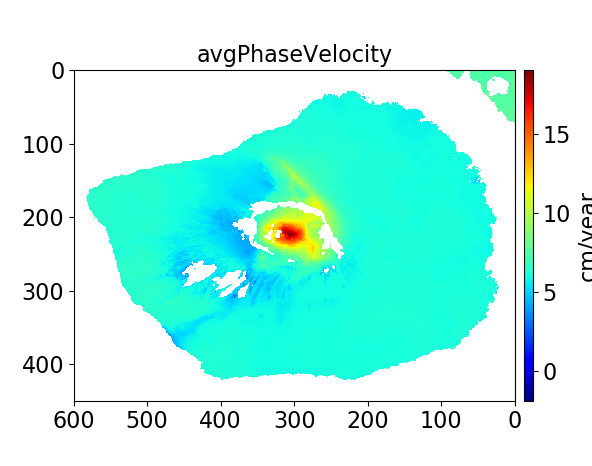

In [14]:
# plot the stacking result
view('avgPhaseVelocity.h5')

### 2.4 Phase-unwrapping error correction (optional)

This step corrects phase-unwrapping errors in the stack of interferograms, supporting the following methods:   
+ bridging
+ phase_closure
+ bridging+phase_closure    
    
If turn on, it will add new dataset named as "unwrapPhase_bridging" or "unwrapPhase_phaseClosure" or "unwrapPhase_bridging_phaseClosure" into the ./INPUTS/ifgramStack.h5 file. The corresonding template options are:
```cfg
pysar.unwrapError.method          = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
pysar.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
pysar.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for no
pysar.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 150, radius in pixel of circular area around bridge ends
```

In this dataset, we turn off (by default) this option and skip this step.

### 2.5 Network modification (optional)

The network inversion result can be biased by outliers of the observations (interferograms). For weighted (by default) network inversion, the outliers are most likely the coherent pixels with remaining phase-unwrapping errors. Thus, we modify the network to exclude interferograms (by setting `dropIfgram = True` in ./INPUTS/ifgramStack.h5 file) affected by remaining coherence phase-unwrapping errors. 

The corresponding template options are:
```cfg
## 3.1.1 Coherence-based network modification = MST + Threshold, by default
## 1) calculate a average coherence value for each interferogram using spatial coherence and input mask (with AOI)
## 2) find a minimum spanning tree (MST) network with inverse of average coherence as weight (keepMinSpanTree)
## 3) for all interferograms except for MST's, exclude those with average coherence < minCoherence.
pysar.network.coherenceBased  = auto  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
pysar.network.keepMinSpanTree = auto  #[yes / no], auto for yes, keep interferograms in Min Span Tree network
pysar.network.minCoherence    = auto  #[0.0-1.0], auto for 0.7
pysar.network.maskFile        = auto  #[file name, no], auto for maskConnComp.h5, no for all pixels
pysar.network.aoiYX           = auto  #[y0:y1,x0:x1 / no], auto for no, area of interest for coherence calculation
pysar.network.aoiLALO         = auto  #[lat0:lat1,lon0:lon1 / no], auto for no - use the whole area
## 3.1.2 Network modification based on temporal/perpendicular baselines, date etc.
pysar.network.tempBaseMax     = auto  #[1-inf, no], auto for no, maximum temporal baseline in days
pysar.network.perpBaseMax     = auto  #[1-inf, no], auto for no, maximum perpendicular spatial baseline in meter
pysar.network.connNumMax      = auto  #[1-inf, no], auto for no, maximum number of neighbors for each acquisition
pysar.network.referenceFile   = auto  #[date12_list.txt / ifgramStack.h5 / no], auto for no
pysar.network.excludeDate     = auto  #[20080520,20090817 / no], auto for no
pysar.network.excludeIfgIndex = auto  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
pysar.network.startDate       = auto  #[20090101 / no], auto for no
pysar.network.endDate         = auto  #[20110101 / no], auto for no
```

<div class="alert alert-danger">
<b>Custom AOI:</b> 
For coherence-based network modification, a customized area of interest that includes the low coherent areas surrounding the areas with coherent phase-unwrapping error is highly recommended. Such as the blue rectangle in the figure below.
</div>

<p align="center">
  <img width=700, src="docs/images/net_modification.jpg">
</p>    
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>    

In this dataset, we turn off (by default) this option and skip this step, becuase there is no remaining phase-unwrapping error on coherent pixels.

### 2.6 Network inversion

This step inverts the network of interferograms for the raw phase time-series. Note that this raw phase time-series includes contributions from ground deformation, atmospheric delay and topographic residual caused by DEM error. 

## Features

+ ### update and re-run

+ ### --start/end/dostep